In [1]:
'''Semi-Supervised Learning with Clustering'''
# Importing the needed libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import numpy as np
pd.options.mode.chained_assignment = None
import warnings
warnings.filterwarnings('ignore')
import statsmodels.formula.api as smf
from sklearn.preprocessing import add_dummy_feature
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeRegressor
from scipy.spatial.transform import Rotation
from sklearn.datasets import load_digits


In [2]:
x, y = load_digits(return_X_y=True)
x_train, y_train = x[:1440],y[:1440]
x_test, y_test = x[1440:],y[1440:]
x_train.shape

(1440, 64)

In [3]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(max_iter=11000)
# if we have random labels for 60 instances:
n_labeled = 60
log_reg.fit(x_train[:n_labeled],y_train[:n_labeled])

LogisticRegression(max_iter=11000)

In [4]:
log_reg.score(x_test,y_test)
# ~75% is not that great

0.7478991596638656

In [5]:
# if I use the entire data set instead score goes up to 90%
lg_full = LogisticRegression(max_iter=11000)
lg_full.fit(x_train,y_train)

LogisticRegression(max_iter=11000)

In [6]:
lg_full.score(x_test,y_test)

0.8991596638655462

In [7]:
# Let's use clustering
from sklearn.cluster import KMeans
k = 50
kmeans_cluster = KMeans(n_clusters=k,
                        n_init=10,random_state=7)
x_clustered = kmeans_cluster.fit_transform(x_train)

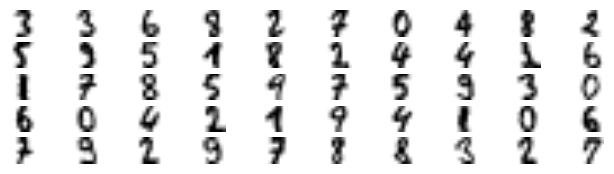

In [8]:
digit_idx = x_clustered.argmin(axis=0)
x_representatives = x_train[digit_idx]
plt.figure(figsize=(8, 2))
for index, x_representative in enumerate(x_representatives):
  plt.subplot(5,10,index+1)
  plt.imshow(x_representative.reshape(8, 8), cmap="binary",
               interpolation="bilinear")
  plt.axis('off')
plt.show()

In [9]:
x_representative.shape

(64,)

In [10]:
y_representatives = np.array([
    3,3,6,8,2,7,0,4,8,2,
    5,9,5,1,8,2,4,4,1,6,
    1,7,8,5,9,7,5,9,3,0,
    6,0,4,2,1,9,4,1,0,6,
    7,9,2,9,7,8,8,3,2,7
])

In [11]:
# So with 50 labeled instances will check score again
# but each represents the ckuster closely not random!!
lg_reg = LogisticRegression(max_iter=11000)
log_reg.fit(x_representatives,y_representatives)

LogisticRegression(max_iter=11000)

In [12]:
log_reg.score(x_test,y_test)

0.8487394957983193

In [13]:
"""Yay! score improved from 74.8 % to 85 %
as this labeling was "targeted" ie closest ones
to cluster center!"""

'Yay! score improved from 74.8 % to 85 %\nas this labeling was "targeted" ie closest ones\nto cluster center!'

In [14]:
x_train.dtype

dtype('float64')

In [15]:
# Label propagation
y_propagate_train = np.empty(x_train.shape[0],dtype=x_train.dtype)
for i in range(k):
  y_propagate_train[kmeans_cluster.labels_==i] = y_representatives[i]

In [16]:
kmeans_cluster.labels_

array([38, 20,  9, ..., 15,  1, 16], dtype=int32)

In [17]:
y_representatives

array([3, 3, 6, 8, 2, 7, 0, 4, 8, 2, 5, 9, 5, 1, 8, 2, 4, 4, 1, 6, 1, 7,
       8, 5, 9, 7, 5, 9, 3, 0, 6, 0, 4, 2, 1, 9, 4, 1, 0, 6, 7, 9, 2, 9,
       7, 8, 8, 3, 2, 7])

In [18]:
# then try same regression again
lg_reg = LogisticRegression(max_iter=11000)
log_reg.fit(x_train,y_propagate_train)

LogisticRegression(max_iter=11000)

In [19]:
# let's check score
log_reg.score(x_test,y_test)

0.8599439775910365

In [20]:
# slight boost but not much
# let's try to eliminate some outliers
closest = 98
x_cluster_distance = x_clustered[np.arange(len(x_train)),kmeans_cluster.labels_]
for i in range(k):
  within_cluster = (kmeans_cluster.labels_==i)
  distance_tocluster = x_cluster_distance[within_cluster]
  distance_cutoff = np.percentile(distance_tocluster,closest)
  above_cutoff = (x_cluster_distance > distance_cutoff)
  x_cluster_distance[within_cluster & above_cutoff] = -7 # hence outliers

partial_propagation = (x_cluster_distance != -7) # outliers excluded
x_train_pp = x_train[partial_propagation] # partially propagated
y_train_pp = y_propagate_train[partial_propagation] # partially propagated

In [21]:
# then try same regression again
g_reg = LogisticRegression(max_iter=11000)
log_reg.fit(x_train_pp,y_train_pp)

LogisticRegression(max_iter=11000)

In [22]:
# let's check score
log_reg.score(x_test,y_test)

0.8683473389355743

In [23]:
# another 1% boost when outliers are excluded.